In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse as ss
from sklearn import tree

In [2]:
#load data, in sparse format
def load_data(filename):
    f = open('../dorothea/%s.data' % filename)
    I,J = [],[]
    for k in range(100000):
        line = f.readline()
        if len(line) == 0:
            print ('done')
            break

        line = [int(x) for x in line.split()]
        J.extend(line)
        I.extend(k for i in range(len(line)))

    return ss.coo_matrix((np.ones(len(I)), (I,J)))


def load_labels(filename):
    f = open('../dorothea/%s.labels' % filename)
    y = []
    for k in range(100000):
        line = f.readline()
        
        if len(line) == 0:
            print ('done')
            break
        y.append(int(line))
    return np.array(y)


Xtrain = load_data('dorothea_train')
ytrain = load_labels('dorothea_train')

Xtest= load_data('dorothea_valid')
ytest = load_labels('dorothea_valid')

print (Xtrain.shape,  Xtest.shape, Xtrain.nnz)

done
done
done
done
(800, 100001) (350, 100001) 727760


In [3]:
def get_class_balance(y):
    #fill me in
    return len(y[y==1])/len(y), len(y[y==-1])/len(y)

print ('class balance is currently %.2f  +1, %.2f -1' % get_class_balance(ytrain))

class balance is currently 0.10  +1, 0.90 -1


This task is different from the other tasks we have done before since the class imbalance is very high. 

In [5]:
def get_misclass(y,yhat):
    #fill me in
    return np.around(np.sum(y!=yhat)/len(y), 3)


def get_f1(y,yhat):
    #fill me in
    def confusion_matrix(y, yhat):
        A = np.empty(shape=(2,2), dtype=int)
        A[0,0] = len(y[(y==yhat)&(y==1)])
        A[1,1] = len(y[(y==yhat)&(y==-1)])
        A[0,1] = len(y[(y!=yhat)&(y==1)])
        A[1,0] = len(y[(y!=yhat)&(y==-1)])
        return A

    def precision(A): return A[0,0]/np.sum(A[:, 0])
    def recall(A): return A[0,0]/np.sum(A[0, :])

    A = confusion_matrix(y, yhat)
    p, r = precision(A), recall(A)
    return np.around(2*p*r/(p+r), 3)

depth = 3
clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=depth, class_weight='balanced')
clf = clf.fit(Xtrain, ytrain)

ypred_train, ypred_test = clf.predict(Xtrain), clf.predict(Xtest)
print (get_misclass(ytrain, ypred_train ), get_f1(ytrain, ypred_train ))
print (get_misclass(ytest, ypred_test ), get_f1(ytest, ypred_test ))

print (get_misclass(ytrain[ytrain==1], ypred_train[ytrain==1]), get_misclass(ytrain[ytrain!=1], ypred_train[ytrain!=1]))
print (get_misclass(ytest[ytest==1], ypred_test[ytest==1]), get_misclass(ytest[ytest!=1], ypred_test[ytest!=1]))

0.041 0.772
0.071 0.603
0.282 0.015
0.441 0.032


In [6]:
train_f1, test_f1 = [], []

for depth in range(1, 11):
    clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=depth,\
                                        class_weight='balanced')
    clf = clf.fit(Xtrain, ytrain)

    train_f1.append(get_f1(ytrain, clf.predict(Xtrain)))
    test_f1.append(get_f1(ytest, clf.predict(Xtest)))

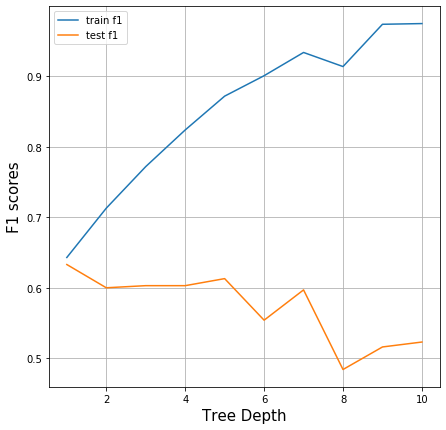

In [7]:
plt.figure(figsize=(7,7))
plt.plot(range(1, 11), train_f1, label="train f1")
plt.plot(range(1, 11), test_f1, label="test f1")
plt.ylabel("F1 scores", fontsize=15)
plt.xlabel("Tree Depth", fontsize=15)
plt.grid(True)
plt.legend()
plt.show()

In [19]:
def KFold(n:int, k:int): 
    a = np.arange(n)
    np.random.seed(420)
    np.random.shuffle(a)
    folds = []
    p = int(n//k)
    for i in range(k-1):
        fold = a[i*p:(i+1)*p]
        folds.append((fold, a[~np.isin(a, fold)]))
    fold = a[(k-1)*p:]
    folds.append((fold, a[~np.isin(a, fold)]))
    return folds

In [20]:
folds = KFold(Xtrain.shape[0], 5)
depth = 1
fold_train_f1, fold_eval_f1 = [], []
for eval, train in folds:
    X_fold_train, y_fold_train = ss.coo_matrix(Xtrain).tocsr()[train], ytrain[train]
    X_fold_eval, y_fold_eval = ss.coo_matrix(Xtrain).tocsr()[eval], ytrain[eval]

    clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=depth,\
                                        class_weight='balanced')
    clf = clf.fit(X_fold_train, y_fold_train)

    fold_train_f1.append(get_f1(y_fold_train, clf.predict(X_fold_train)))
    fold_eval_f1.append(get_f1(y_fold_eval, clf.predict(X_fold_eval)))    

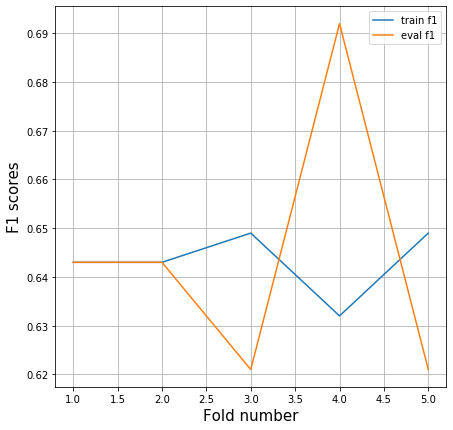

In [21]:
plt.figure(figsize=(7,7))
plt.plot(range(1, 6), fold_train_f1, label="train f1")
plt.plot(range(1, 6), fold_eval_f1, label="eval f1")
plt.ylabel("F1 scores", fontsize=15)
plt.xlabel("Fold number", fontsize=15)
plt.grid(True)
plt.legend()
plt.show()

In [22]:
depth = 10
fold_depth_train_f1, fold_depth_eval_f1 = [], []
for eval, train in folds:
    depth_train_f1, depth_eval_f1 = [], []
    for d in range(1,depth+1):
        
        X_fold_train, y_fold_train = ss.coo_matrix(Xtrain).tocsr()[train], ytrain[train]
        X_fold_eval, y_fold_eval = ss.coo_matrix(Xtrain).tocsr()[eval], ytrain[eval]

        clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=d,\
                                            class_weight='balanced')
        clf = clf.fit(X_fold_train, y_fold_train)
        depth_train_f1.append(get_f1(y_fold_train, clf.predict(X_fold_train)))
        depth_eval_f1.append(get_f1(y_fold_eval, clf.predict(X_fold_eval)))

    fold_depth_train_f1.append(depth_train_f1)
    fold_depth_eval_f1.append(depth_eval_f1)

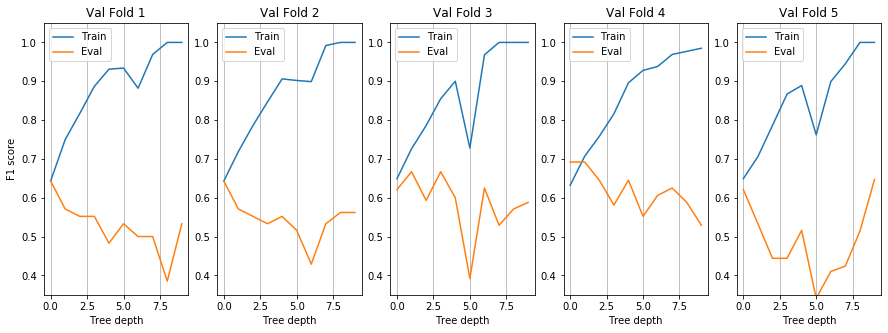

In [23]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for fold in range(len(folds)):
    axs[fold].plot(range(len(fold_depth_train_f1[fold])), fold_depth_train_f1[fold], label="Train")
    axs[fold].plot(range(len(fold_depth_eval_f1[fold])), fold_depth_eval_f1[fold], label="Eval")
    axs[fold].grid(axis="x")
    axs[fold].set_xlabel("Tree depth")
    axs[fold].set_title(f"Val Fold {fold+1}")
    axs[fold].legend()
    axs[fold].legend()
    axs[fold].set_ylim(0.35, 1.05)


axs[0].set_ylabel("F1 score")
plt.show()

In [24]:
eval_f1 = []
for depth in range(1, 11):
    temp_fold_eval_f1 = []
    for eval, train in folds:
        X_fold_train, y_fold_train = ss.coo_matrix(Xtrain).tocsr()[train], ytrain[train]
        X_fold_eval, y_fold_eval = ss.coo_matrix(Xtrain).tocsr()[eval], ytrain[eval]

        clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=depth,\
                                            class_weight='balanced')
        clf = clf.fit(X_fold_train, y_fold_train)

        #fold_train_f1.append(get_f1(y_fold_train, clf.predict(X_fold_train)))
        temp_fold_eval_f1.append(get_f1(y_fold_eval, clf.predict(X_fold_eval)))
    eval_f1.append(np.mean(temp_fold_eval_f1))

In [25]:
test_f1

[0.633, 0.6, 0.603, 0.603, 0.613, 0.554, 0.597, 0.484, 0.516, 0.523]

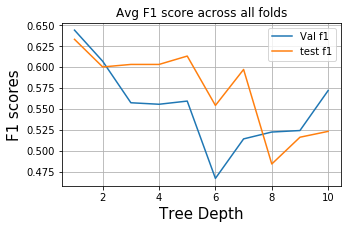

In [26]:
plt.figure(figsize=(5,3))
#plt.plot(range(1, 11), eval_f1, label="Val f1")
#plt.plot(range(1, 11), test_f1, label="test f1")
plt.plot(range(1, 11), np.mean(fold_depth_eval_f1, axis=0), label="Val f1")
plt.plot(range(1, 11), test_f1, label="test f1")
plt.title("Avg F1 score across all folds", fontsize=12)
plt.ylabel("F1 scores", fontsize=15)
plt.xlabel("Tree Depth", fontsize=15)
plt.grid(True)
plt.legend()
plt.show()